# MNIST 数据库

In [1]:
import torch
import torchvision

from torch import nn

from matplotlib import pyplot as plt
from matplotlib_inline import backend_inline

backend_inline.set_matplotlib_formats('svg')

In [2]:
## 导入MNIST数据
trans = torchvision.transforms.ToTensor()

def load_mnist(batch_size):
  mnist_train = torchvision.datasets.MNIST(root="../data", train=True, transform=trans, download=True)
  mnist_test = torchvision.datasets.MNIST(root="../data", train=False, transform=trans, download=True)
  train_iter = torch.utils.data.DataLoader(mnist_train, batch_size, shuffle=True)
  test_iter = torch.utils.data.DataLoader(mnist_test, batch_size, shuffle=False)
  return train_iter, test_iter

## 准确度
def accuracy(y_hat, y):
  y_hat = y_hat.argmax(dim=1)
  cmp = y_hat.type(y.dtype) == y
  return float(cmp.type(y.dtype).sum())

def evaluate_accuracy(net, data_iter):
  net.eval()
  num_correct = 0
  num_total = 0
  with torch.no_grad():
    for X, y in data_iter:
      num_correct += accuracy(net(X), y)
      num_total += y.numel()
  return num_correct / num_total

## 参数初始化
def init_weights(m):
  if type(m) == nn.Linear:
    nn.init.normal_(m.weight,std=0.01)

## 训练（一个迭代周期）
def train_epoch(net, train_iter, loss, updater):
  net.train()
  for X, y in train_iter:
    y_hat = net(X)
    l = loss(y_hat, y)
    updater.zero_grad()
    l.backward()
    updater.step()

## 训练模型
def train(net, train_iter, test_iter, loss, num_epochs, updater):
  for epoch in range(num_epochs):
    train_epoch(net, train_iter, loss, updater)
    acc = evaluate_accuracy(net, test_iter)
    print(f'epoch {epoch + 1}, accuracy {acc:f}')

In [3]:
## 数据集可视化
def show_images(imgs, num_rows, num_cols, titles=None):
  _, axes = plt.subplots(num_rows, num_cols)
  axes = axes.flatten()
  for i, (ax, img) in enumerate(zip(axes, imgs)):
    ax.imshow(img)
    ax.axis('off')
    if titles:
      ax.set_title(titles[i])
  return axes

def show_mnist(num_rows, num_cols):
  fig_size = num_rows * num_cols
  train_iter, _ = load_mnist(batch_size=fig_size)
  for X, y in train_iter:
    break
  show_images(X.reshape(fig_size, 28, 28), num_rows, num_cols, titles=list(y.numpy()))

In [28]:
def show_predict(net, test_iter, n=9):
  for X, y in test_iter: break
  trues = list(y.numpy())
  preds = list(net(X).argmax(dim=1).numpy())
  titles = [f'{true}\n{pred}' for true, pred in zip(trues, preds)]
  show_images(X[0:n].reshape(n,28,28), 1, n, titles=titles[0:n])

In [5]:
## 超参数
num_inputs = 28*28
num_outputs = 10
num_hiddens = 256
batch_size = 256
learning_rate = 0.1
num_epochs = 10

train_iter, test_iter = load_mnist(batch_size)

## 模型
net = nn.Sequential(nn.Flatten(),
                    nn.Linear(num_inputs, num_hiddens),
                    nn.SELU(),
                    nn.Linear(num_hiddens, num_outputs))
net.apply(init_weights)

## 损失函数
loss = nn.CrossEntropyLoss()

## 优化算法
trainer = torch.optim.SGD(net.parameters(), lr=learning_rate)

## 训练
train(net, train_iter, test_iter, loss, num_epochs, trainer)

epoch 1, accuracy 0.896600
epoch 2, accuracy 0.913200
epoch 3, accuracy 0.918400
epoch 4, accuracy 0.922500
epoch 5, accuracy 0.924200
epoch 6, accuracy 0.928000
epoch 7, accuracy 0.930200
epoch 8, accuracy 0.931400
epoch 9, accuracy 0.934400
epoch 10, accuracy 0.940200


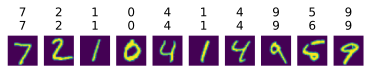

In [6]:
show_predict(net, test_iter, 10)

In [7]:
net = nn.Sequential(nn.Flatten(),
                    nn.Linear(num_inputs, num_hiddens),
                    nn.ReLU(),
                    nn.Linear(num_hiddens, num_outputs))
net.apply(init_weights)

## 损失函数
loss = nn.CrossEntropyLoss()

## 优化算法
trainer = torch.optim.SGD(net.parameters(), lr=learning_rate)

## 训练
train(net, train_iter, test_iter, loss, num_epochs, trainer)

epoch 1, accuracy 0.883100
epoch 2, accuracy 0.904600
epoch 3, accuracy 0.917700
epoch 4, accuracy 0.926100
epoch 5, accuracy 0.931600
epoch 6, accuracy 0.932400
epoch 7, accuracy 0.942200
epoch 8, accuracy 0.945400
epoch 9, accuracy 0.948200
epoch 10, accuracy 0.950100


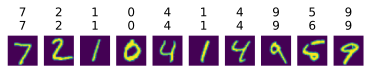

In [8]:
show_predict(net, test_iter, 10)

In [11]:
num_hiddens = 1024
learning_rate = 0.5
num_epochs = 10

train_iter, test_iter = load_mnist(batch_size)

## 模型
net = nn.Sequential(nn.Flatten(),
                    nn.Linear(num_inputs, num_hiddens),
                    nn.ReLU(),
                    nn.Linear(num_hiddens, num_outputs))
net = torch.jit.script(net)
net.apply(init_weights)

## 损失函数
loss = nn.CrossEntropyLoss()

## 优化算法
trainer = torch.optim.SGD(net.parameters(), lr=learning_rate)

## 训练
train(net, train_iter, test_iter, loss, num_epochs, trainer)

epoch 1, accuracy 0.932800
epoch 2, accuracy 0.957100
epoch 3, accuracy 0.969100
epoch 4, accuracy 0.969900
epoch 5, accuracy 0.972400
epoch 6, accuracy 0.968900
epoch 7, accuracy 0.975900
epoch 8, accuracy 0.975800
epoch 9, accuracy 0.979700
epoch 10, accuracy 0.977900


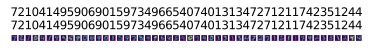

In [14]:
show_predict(net, test_iter, 50)

In [38]:
num_hiddens = 1024
learning_rate = 0.5
num_epochs = 10
gpu = torch.device('cuda')

def train_epoch(net, train_iter, loss, updater):
  net.train()
  for X, y in train_iter:
    X, y = X.to(gpu), y.to(gpu)
    y_hat = net(X)
    l = loss(y_hat, y)
    updater.zero_grad()
    l.backward()
    updater.step()

def evaluate_accuracy(net, data_iter):
  net.eval()
  num_correct = 0
  num_total = 0
  with torch.no_grad():
    for X, y in data_iter:
      X, y = X.to(gpu), y.to(gpu)
      num_correct += accuracy(net(X), y)
      num_total += y.numel()
  return num_correct / num_total


train_iter, test_iter = load_mnist(batch_size)

## 模型
net = nn.Sequential(nn.Flatten(),
                    nn.Linear(num_inputs, num_hiddens),
                    nn.ReLU(),
                    nn.Linear(num_hiddens, num_outputs))
net = net.to(gpu)
net = torch.jit.script(net)
net.apply(init_weights)

## 损失函数
loss = nn.CrossEntropyLoss()
loss = loss.to(gpu)

## 优化算法
trainer = torch.optim.SGD(net.parameters(), lr=learning_rate)

## 训练
train(net, train_iter, test_iter, loss, num_epochs, trainer)

epoch 1, accuracy 0.942300
epoch 2, accuracy 0.954400
epoch 3, accuracy 0.962200
epoch 4, accuracy 0.964000
epoch 5, accuracy 0.976100
epoch 6, accuracy 0.974500
epoch 7, accuracy 0.976100
epoch 8, accuracy 0.977300
epoch 9, accuracy 0.977700
epoch 10, accuracy 0.979900


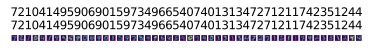

In [39]:
show_predict(net.to('cpu'), test_iter, 50)

In [57]:
from torch.utils.data import DataLoader
from torch.utils.data.dataloader import default_collate

def load_mnist(batch_size):
  mnist_train = torchvision.datasets.MNIST(root="../data", train=True, transform=trans, download=True)
  mnist_test = torchvision.datasets.MNIST(root="../data", train=False, transform=trans, download=True)
  train_iter = DataLoader(mnist_train, batch_size, shuffle=True,
                          collate_fn=lambda x: tuple(x_.to('cuda') for x_ in default_collate(x)))
  test_iter = DataLoader(mnist_test, batch_size, shuffle=False,
                         collate_fn=lambda x: tuple(x_.to('cuda') for x_ in default_collate(x)))
  return train_iter, test_iter

def evaluate_accuracy(net, data_iter):
  net.eval()
  num_correct = 0
  num_total = 0
  with torch.no_grad():
    for X, y in data_iter:
      num_correct += accuracy(net(X), y)
      num_total += y.numel()
  return num_correct / num_total

## 训练（一个迭代周期）
def train_epoch(net, train_iter, loss, updater):
  net.train()
  for X, y in train_iter:
    y_hat = net(X)
    l = loss(y_hat, y)
    updater.zero_grad()
    l.backward()
    updater.step()

In [48]:
num_hiddens = 1024
learning_rate = 0.5
num_epochs = 10

train_iter, test_iter = load_mnist(batch_size)

## 模型
net = nn.Sequential(nn.Flatten(),
                    nn.Linear(num_inputs, num_hiddens),
                    nn.ReLU(),
                    nn.Linear(num_hiddens, num_outputs))
net = net.to(gpu)
net = torch.jit.script(net)
net.apply(init_weights)

## 损失函数
loss = nn.CrossEntropyLoss()
loss = loss.to(gpu)

## 优化算法
trainer = torch.optim.SGD(net.parameters(), lr=learning_rate)

## 训练
train(net, train_iter, test_iter, loss, num_epochs, trainer)

epoch 1, accuracy 0.937400
epoch 2, accuracy 0.955300
epoch 3, accuracy 0.960300
epoch 4, accuracy 0.971300
epoch 5, accuracy 0.974600
epoch 6, accuracy 0.975500
epoch 7, accuracy 0.975500
epoch 8, accuracy 0.978500
epoch 9, accuracy 0.979800
epoch 10, accuracy 0.980100
